# Downloading and processing LiDAR data and aerial photograph

This notebook gives a toturial which treats the subjects of getting LiDAR data, and give it a color using aerial photgraphs.

In [7]:
# Import packages
import logging
import timeit
import json
import os
import urlparse

logging.root.setLevel(logging.DEBUG)

# computing
import numpy as np
#plotting
import matplotlib.pyplot as plt
# for spatial types
import owslib.wfs
import owslib.wms
# for spatial operations
import shapely.geometry
from matplotlib import collections
# for pointclouds
import liblas
# numpy compatible, uncompressed only for now
import laspy.file
# for downloading
import requests
#  for xml parsing
import lxml.etree

%matplotlib inline

## LiDAR

The lidar data from the dutch ahn2 dataset is split up into tiles of 5 by 6.25 kilometers. To find out which tile we need to download in order to get the data we want, we can use the WFS. This is extensively discribed in the ahn2 notebook available in the github/notebooks repositry.

In [2]:
# Enter WFS properties
wfsurl = 'http://geodata.nationaalgeoregister.nl/ahn2/wfs'
wfs = owslib.wfs.WebFeatureService(wfsurl, version="2.0.0")
wfslayer = wfs.contents['ahn2:ahn2_bladindex']

# Get boxes from WFS
f = wfs.getfeature(typename=[wfslayer.id], outputFormat="json")
data = json.load(f)

shapes = []
tiles = []

# create a list of tiles and shapes
for feature in data['features']:
    shapes.append(shapely.geometry.asShape(feature['geometry'])[0])
    tiles.append(shapes[-1].exterior.coords[:])

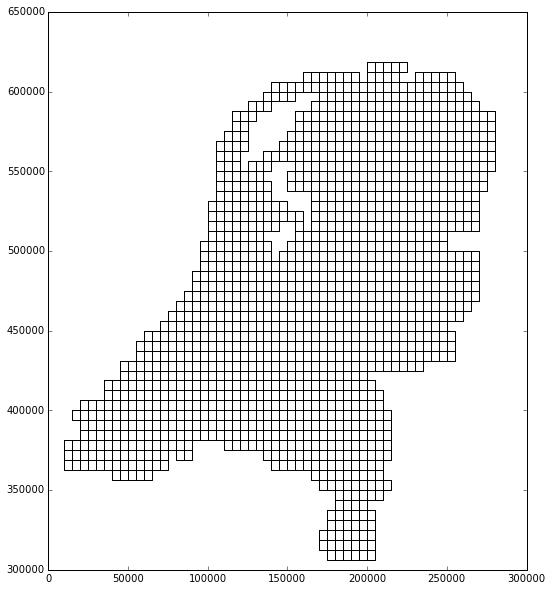

In [3]:
# Plot boxes using a collection
col = collections.LineCollection(tiles, colors = 'k')
fig, ax  = plt.subplots()
fig.set_size_inches(10,10)
ax.add_collection(col, autolim = True)
ax.set_aspect('equal')
ax.autoscale_view()

The coordinates are in the Dutch RijksDriehoekstelsel.

In [8]:
# Center of Delft in RD-coordinates:
x = 84468 
y = 447557

# Create a shapely point
p = shapely.geometry.Point(x, y)

# Check in which box the point lies
for i, shape in enumerate(shapes):
    if p.within(shape):
        bladnr = data['features'][i]['properties']['bladnr']
        delftshape = shape
        logging.info('The point is in box %s.', bladnr)
        break

INFO:root:The point is in box 37en1.


Now we need to download the lidar tile 37en1. We can do this by parsing the feeds that contain the urls:
- http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_uitgefilterd.xml 
- http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_gefilterd.xml 

This allows us to search for our box. There are two links since there are two datasets. One, 'gefilterd', contains the point cloud with all the objects (houses, trees, etcetera) removed. The other 'uitgefilterd' contains these objects. We will need both of them. Let's download 37en1 for both. This might take a while because the total is almost 1GB.

When we have downloaded and unpacked the files, we get two laz files. 

In [11]:

urls = [
    'http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_uitgefilterd.xml',
    'http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_gefilterd.xml'
]
for url in urls:
    response = requests.get(url)
    tree = lxml.etree.parse(url)
    links = tree.findall('//{http://www.w3.org/2005/Atom}link')
    links = [link.attrib['href'] for link in links if bladnr in  link.attrib['href']]
    link = links[0]
    filename = os.path.split(urlparse.urlsplit(link).path)[-1]
    newname = filename.replace('.zip', '')
    
    #  skip if the extracted file is already there
    if not os.path.exists(newname ):
        # continue downloading
        !wget -c $link
        !unzip -o $filename
    !lasinfo --no-check $newname




INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/atom/ahn2_uitgefilterd.xml HTTP/1.1" 200 None


---------------------------------------------------------
  Header Summary
---------------------------------------------------------

  Version:                     1.2
  Source ID:                   0
  Reserved:                    0
  Project ID/GUID:             '00000000-0000-0000-0000-000000000000'
  System ID:                   'LAStools (c) by Martin Isenburg'
  Generating Software:         'lasmerge (version 130623)'
  File Creation Day/Year:      235/2010
  Header Byte Size             227
  Data Offset:                 321
  Header Padding:              0
  Number Var. Length Records:  1
  Point Data Format:           0
  Number of Point Records:     204079982
  Compressed:                  True
  Compression Info:            LASzip Version 2.1r0 c2 50000: POINT10 2
  Number of Points by Return:  204079982 0 0 0 0 
  Scale Factor X Y Z:          0.01000000000000 0.01000000000000 0.01000000000000
  Offset X Y Z:                0.00 400000.00 0.00
  Min X Y Z:                  

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/atom/ahn2_gefilterd.xml HTTP/1.1" 200 None


---------------------------------------------------------
  Header Summary
---------------------------------------------------------

  Version:                     1.2
  Source ID:                   0
  Reserved:                    0
  Project ID/GUID:             '00000000-0000-0000-0000-000000000000'
  System ID:                   'LAStools (c) by Martin Isenburg'
  Generating Software:         'lasmerge (version 130623)'
  File Creation Day/Year:      252/2010
  Header Byte Size             227
  Data Offset:                 321
  Header Padding:              0
  Number Var. Length Records:  1
  Point Data Format:           0
  Number of Point Records:     402585746
  Compressed:                  True
  Compression Info:            LASzip Version 2.1r0 c2 50000: POINT10 2
  Number of Points by Return:  402585746 0 0 0 0 
  Scale Factor X Y Z:          0.01000000000000 0.01000000000000 0.01000000000000
  Offset X Y Z:                0.00 400000.00 0.00
  Min X Y Z:                  

The laz files contain the x, y and z coordinates of the point cloud. Let's see what's inside the file

In [9]:
fileloc = '.'
files = ['g37en1.laz' , 'u37en1.laz']

count = 0
lasfiles = []
for f in files:
    lasfiles.append(liblas.file.File(f, mode = 'r'))
    count += lasfiles[-1].get_header().get_count()
    
logging.info('The number of points in the cloud is %s.', count)
logging.info('The number of points per square meter is %s.', count/delftshape.area)

INFO:root:The number of points in the cloud is 606665728.
INFO:root:The number of points per square meter is 19.413303296.


That are over 600 million points! Since this number is to high for the visualization we aim te make, we will reduce our area to an area of 500 x 500 m in the center of Delft. This will give us 5 million points which should be processable.

The problem with getting our five million points is that we cannot know the location of the point on beforehand. Also the points have to be extracted one by one, so building in an if-statement to check the location will greatly increase the computation time. Extracting all point will probably take more than an hour and some memory problems so we wont do that.

We do however know that the point are somewhat grouped in subtiles within the las files (Trust me on that one). So if we take a sample of 10000 points, and check if they are in our range plus some buffer, we roughly know which part of the las file is in our range. This way our computation time will be under 10 minutes, and we will cover most points. Let's select the bounds and extract a sample. This will probably take about two minutes.

In [ ]:
%%file wms.xml
<GDAL_WMS>
  <Service name="WMS">
    <Version>1.0.0</Version>
    <wmtver>1.0.0</wmtver>
    <ServerUrl>http://geodata1.nationaalgeoregister.nl/luchtfoto/wms?wmtver=1.0</ServerUrl>
    <Layers>luchtfoto</Layers>
    <SRS>EPSG:28992</SRS>
  </Service>
  <DataWindow>
    <UpperLeftX>80000</UpperLeftX>
    <UpperLeftY>450000</UpperLeftY>
    <LowerRightX>85000</LowerRightX>
    <LowerRightY>443750</LowerRightY>
    <SizeX>1000</SizeX>
    <SizeY>1000</SizeY>
  </DataWindow>
  <Projection>EPSG:28992</Projection>
  <BlockSizeX>256</BlockSizeX>
  <BlockSizeY>256</BlockSizeY>
</GDAL_WMS>

In [ ]:
%%bash
gdal_translate wms.xml u37en1.tiff
las2las --color-source u37en1.tiff \
        --color-source-bands 1 2 3 \
        --color-source-scale 256 \
        --point-format 3 \
        -i u37en1.laz -o u37en1_color.laz
PotreeConverter u37en1_color.laz -l 9 --generate-page -o u37en1_color

In [13]:
bounds      = (x-250, y-250, x+250, y+250)
outerbounds = (x-500, y-500, x+500, y+500)
minx, miny, maxx, maxy = outerbounds

In [18]:
#pff slow, reading takes about 10 seconds per million points
# reading the uncompressed 8GB files is faster than reading the files with liblas python wrapper. 
files = ['g37en1.laz' , 'u37en1.laz']
for f in files:
    new_f = f.replace('.laz', '.las')
    if not os.path.exists(new_f):
        !las2las --input $f --minx $minx --miny $miny --maxx $maxx --maxy $maxy --output $new_f

In [21]:
lasfile = laspy.file.File(f.replace('.laz', '.las'))
%timeit lasfile.X
lasfile.X.shape

The slowest run took 7.63 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.44 µs per loop


(12052221,)

In [103]:
import laspy.file
for f in files:
    laspy.file.File(f.replace('.laz', '.las'))
    

In [64]:
# Create a function to get the index and coordinates from the laz file
def yield_points(lasfile):
    """sample points from las files"""
    
    npoints = lasfile.get_header().get_count()
    start = 10000
    stop = npoints+1
    step = 2000
    for p in lasfile[start:stop:step]:
        yield (p.x, p.y, p.z)
xyzs = []
for lasfile in lasfiles:
    xyzs.append(np.array(list(yield_points(lasfile))))
            


Now filter out the point within our bounds and make a scatterplot to see if the selection is succesfull

In [65]:
for i, xyz in enumerate(xyzs):
    index = np.logical_and.reduce([
        xyz[:,0] > outerbounds[0],
        xyz[:,0] < outerbounds[2],
        xyz[:,1] > outerbounds[1],
        xyz[:,1] < outerbounds[3]
    ])
    xyzs[i] = xyz[index,:]



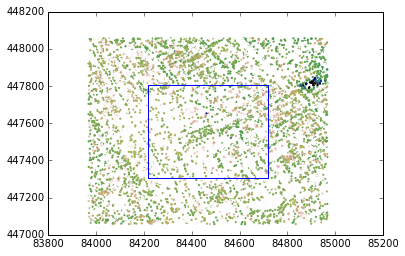

In [66]:
import matplotlib.colors
import matplotlib.cm
N = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.gist_earth

for xyz in xyzs:
    colors = cmap(N(xyz[:,2]))
    plt.scatter(xyz[:,0], xyz[:,1], c=colors, marker='.', edgecolor='none')
plt.plot([bounds[0], bounds[0], bounds[2], bounds[2], bounds[0]], [bounds[1], bounds[3], bounds[3], bounds[1], bounds[1]], 'b-')

Around the selected points we want the 10000 points before and 10000 points after.

In [16]:
subranges = []
for i in range(len(lasfiles)):
    subrange = []
    for j in xyz[i]:
        subrange.append([int(j[0]-step/2.), int(j[0]+step/2.)])
    subranges.append(subrange)

And get the points from the subrange, I suggest you take a break:

In [17]:
# Create another function to retrieve points. Note that this one is different since it does not return the index.
def las2rows(lasfile, start, stop):
    
    for i in xrange(start, stop, 1):
        p = lasfile.read(i)
        yield p.x
        yield p.y
        yield p.z

starttime = timeit.default_timer()
xyz = []
for i in range(len(lasfiles)):
    for subr in subranges[i]:
        npoints = subr[1] - subr[0]
        xyz.append(np.fromiter(las2rows(lasfiles[i], subr[0], subr[1]), np.float32, npoints*3).reshape(npoints, 3))
    
print 'Extracting time: {} s.'.format(timeit.default_timer()-starttime)

xyz = np.vstack(xyz).astype(np.float32)
print 'There are {} points in our extracted set.'.format(len(xyz))

Extracting time: 222.470582962 s.
There are 18480000 points in our extracted set.


And finally filter out the points we need again:

In [18]:
index = ((xyz[:,0] > bounds[0]) *
         (xyz[:,0] < bounds[2]) *
         (xyz[:,1] > bounds[1]) *
         (xyz[:,1] < bounds[3]))

xyz = xyz[index,:]
print 'There are {} points in our bounded set.'.format(len(xyz))

There are 4266958 points in our bounded set.


## Aerial photographs

We will also need the color values to make a nice visualisation. For this we will use luchtfotos which we will get via WMS. The maximum size for our request is about 16 MP. The accuracy of the aerial photgraphs is 0.5 meter. We choose 1250 x 1250 pizels for our 500 x 500 area, which is the maximum reolution we can request. The reason for this has probably something to do with the accuracy.

In [19]:
# Get WMS layer
wmsurl   = 'http://geodata1.nationaalgeoregister.nl/luchtfoto/wms'
wms      = owslib.wms.WebMapService(wmsurl)
wmslayer = ['luchtfoto_png']            

# Download aerial photograps
for i in range(1):
    f = wms.getmap(layers = wmslayer,
                   srs    = 'EPSG:28992',
                   bbox   = bounds,
                   size   = (1250, 1250),
                   format = 'image/png')
    rgb = (plt.imread(f)*255).astype(np.uint8)

We increase the saturation a bit to make the colors a little less gray and plot the image to see the result.

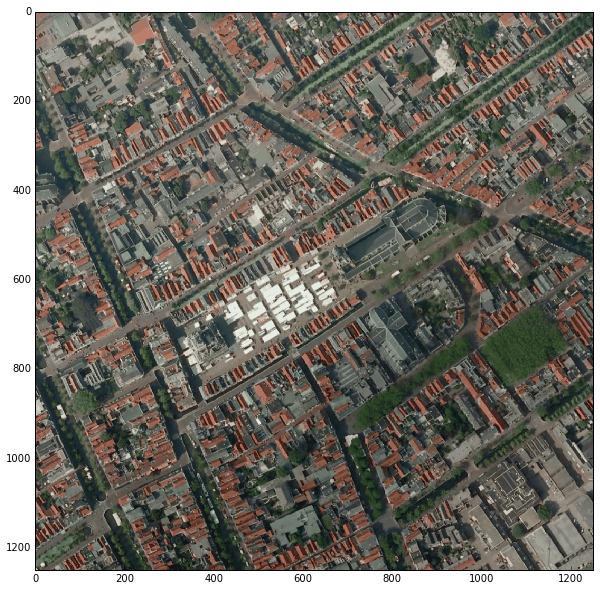

In [20]:
# Increase saturation
from skimage import color
rgb = color.rgb2hsv(rgb)
rgb[:,:,1] *= 1.5
rgb = color.hsv2rgb(rgb)

# Plot figure
fig, ax  = plt.subplots()
fig.set_size_inches(10,10)
ax.imshow(rgb)

Now we have the x, y, z and r, g, b values, let's combine them!

## Combining LiDAR with colors

The next step is to combine the xyz and rgb. A nice way is to calculate the relative distance of the x and y coordinate in the picture and use this to get the right color pixel.

In [21]:
# Allocate array for colors. Use an uint8 datatype, since we do not need more and it saves space.
colors = np.empty((len(xyz),3), dtype = np.uint8)        

# number of pixels in x and y direction
xpix = int(rgb.shape[1])
ypix = int(rgb.shape[0])

# xrel and yrel are the i'th and j'th pixel from the top left
xrel = np.floor(((xyz[:, 0]-bounds[0])/(bounds[2]-bounds[0])*xpix)).astype(np.uint16)
yrel = np.floor(((bounds[3]-xyz[:, 1])/(bounds[3]-bounds[1])*ypix)).astype(np.uint16)

# If an xyz coordinate is on the right edge of the box, it gives trouble when assigning
# a color to it. Shift the xrel value therefor one place back
xrel[xrel == rgb.shape[1]] = rgb.shape[1] - 1
yrel[yrel == rgb.shape[0]] = rgb.shape[0] - 1

# Get colors matching with x and y coordinates
colors[:, 0] = rgb[yrel, xrel][:, 0]*255
colors[:, 1] = rgb[yrel, xrel][:, 1]*255
colors[:, 2] = rgb[yrel, xrel][:, 2]*255

Check the output:

In [22]:
for cor, col in zip(xyz[:10,:], colors[:10,:]):
    print 'xyz: {};  rgb: {}'.format(cor, col)

xyz: [  8.47170078e+04   4.47502594e+05   4.90000010e-01];  rgb: [36 42 36]
xyz: [  8.47179688e+04   4.47518781e+05   6.89999998e-01];  rgb: [77 82 80]
xyz: [  8.47179219e+04   4.47518375e+05   7.20000029e-01];  rgb: [77 82 80]
xyz: [  8.47175078e+04   4.47514875e+05   6.80000007e-01];  rgb: [70 77 63]
xyz: [  8.47174531e+04   4.47514469e+05   7.50000000e-01];  rgb: [64 60 55]
xyz: [  8.47173984e+04   4.47514031e+05   7.50000000e-01];  rgb: [56 50 45]
xyz: [  8.47173516e+04   4.47513594e+05   7.50000000e-01];  rgb: [43 41 38]
xyz: [  8.47172891e+04   4.47513156e+05   7.90000021e-01];  rgb: [37 37 39]
xyz: [  8.47171797e+04   4.47512312e+05   8.39999974e-01];  rgb: [53 56 59]
xyz: [  8.47161875e+04   4.47503375e+05   5.60000002e-01];  rgb: [34 41 46]


This looks good. Now save the files as .npy format or numpy memory map (or something else if you like). Memory maps allow parts of large datasets to be loaded quickly. This saves memory and processing time, which both can be usefull while working with point clouds. The rticky part with memory maps is that the shape is not saved as metadata, but is needed when the file is loaded. So some sort of administration is needed.

In [23]:
# Numpy array
np.save(r'xyz_delft_center', xyz)
np.save(r'rgb_delft_center', colors)

# Numpy memory map
xyz_mmap = np.memmap(r'xyz_mmap_delft_center.dat', dtype = 'float32', mode = 'w+', shape = xyz.shape)
xyz_mmap[:] = xyz[:]
del xyz_mmap

rgb_mmap = np.memmap(r'rgb_mmap_delft_center.dat', dtype = 'uint8', mode = 'w+', shape = rgb.shape)
rgb_mmap[:] = rgb[:]
del rgb_mmap

In the notebook about plotting point clouds with Mayavi will be explained how to visualize this data in combination with model results.